# Estimating the Drift-Diffusion Model

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

## Import the Data Set

In [2]:
rt_data = pd.read_csv("./sample_response_times.csv", delimiter=";")
rt_data.head()

,rt,choice,condition
0,0.477,1.0,1.0
1,0.600,1.0,1.0
2,0.500,0.0,1.0
3,0.416,1.0,1.0
4,0.435,1.0,1.0


Text(0.5, 1.0, 'Condition 1')

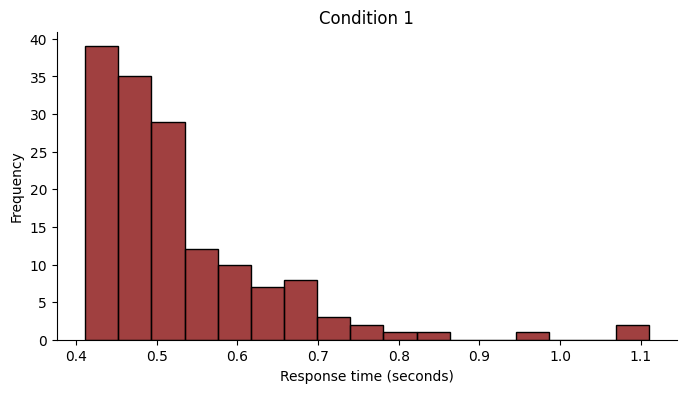

In [3]:
rts = rt_data.rt.values
conditions = rt_data.condition.values
f, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.histplot(rts[conditions==1.0], color='maroon', ax=ax)
sns.despine(ax=ax)
ax.set_xlabel('Response time (seconds)')
ax.set_ylabel('Frequency')
ax.set_title("Condition 1")

Text(0.5, 1.0, 'Condition 2')

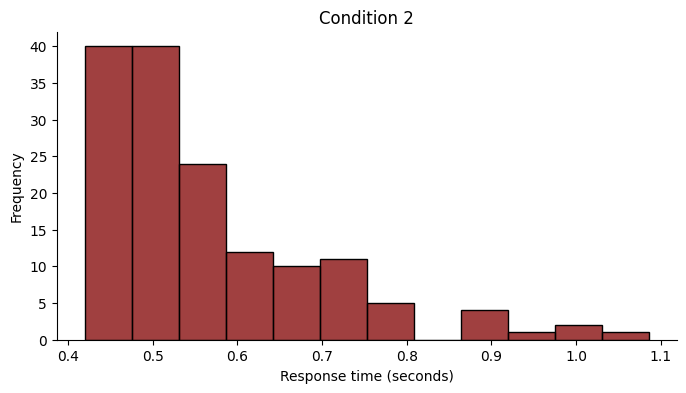

In [4]:
f, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.histplot(rts[conditions==2.0], color='maroon', ax=ax)
sns.despine(ax=ax)
ax.set_xlabel('Response time (seconds)')
ax.set_ylabel('Frequency')
ax.set_title("Condition 2")

## Diffusion Model with Stan

The drift rate (v) is the parameter that best reflects task difficulty. The harder problem (picking out a familiar face in a crowd of 100) will have a lower drift rate than the easier problem (picking out a familiar face in a crowd of 10).

In [5]:
program_code = """

data {
    int<lower=1> N;
    array[N] real<lower=0> rt;
    array[N] int<lower=0, upper=1> choice;
    array[N] int<lower=1, upper=2> condition;
}

parameters {
    real<lower=0> v1;
    real<lower=0> v2;
    real<lower=0> a;
    real<lower=0, upper=1> beta;
    real<lower=0> tau;
}

model {
    // Priors
    v1 ~ gamma(3, 1);
    v2 ~ gamma(3, 1);
    a ~ gamma(3, 1);
    beta ~ beta(2, 2);
    tau ~ gamma(2, 1);

    // Likelihood (Wiener Model)
    for (n in 1:N) {
        if (condition[n] == 1) {
            if (choice[n] == 1) {
                rt[n] ~ wiener(a, tau, beta, v1);
            } else {
                rt[n] ~ wiener(a, tau, 1-beta, -v1);
            }
        }
        
        if (condition[n] == 2) {
            if (choice[n] == 1) {
                rt[n] ~ wiener(a, tau, beta, v2);
            } else {
                rt[n] ~ wiener(a, tau, 1-beta, -v2);
            }
        }
    }
}

"""

data_dict = {
    "rt": rt_data.rt.values,
    "choice": rt_data.choice.values.astype(int),
    "condition": rt_data.condition.values.astype(int),
    "N": rt_data.rt.values.shape[0]
}

In [6]:
### Build model
model = stan.build(program_code=program_code, data=data_dict)

Building...



Building: found in cache, done.

In [7]:
### Fit model
fit = model.sample(num_chains=4, num_samples=2500, num_warmup=1000)

Sampling:   0%
Sampling:   0% (1/14000)
Sampling:   0% (2/14000)
Sampling:   0% (3/14000)
Sampling:   1% (102/14000)
Sampling:   1% (201/14000)
Sampling:   2% (300/14000)
Sampling:   3% (400/14000)
Sampling:   4% (500/14000)
Sampling:   4% (600/14000)
Sampling:   5% (700/14000)
Sampling:   6% (800/14000)
Sampling:   6% (900/14000)
Sampling:   7% (1000/14000)
Sampling:   8% (1100/14000)
Sampling:   9% (1200/14000)
Sampling:   9% (1300/14000)
Sampling:  10% (1400/14000)
Sampling:  11% (1500/14000)
Sampling:  11% (1600/14000)
Sampling:  12% (1700/14000)
Sampling:  13% (1800/14000)
Sampling:  14% (1900/14000)
Sampling:  15% (2100/14000)
Sampling:  16% (2300/14000)
Sampling:  17% (2400/14000)
Sampling:  18% (2500/14000)
Sampling:  19% (2701/14000)
Sampling:  21% (2902/14000)
Sampling:  23% (3202/14000)
Sampling:  29% (4102/14000)
Sampling:  47% (6601/14000)
Sampling:  65% (9100/14000)
Sampling:  81% (11400/14000)
Sampling: 100% (14000/14000)
Sampling: 100% (14000/14000), done.
Messages rece

In [8]:
fit.to_frame().head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,v1,v2,a,beta,tau
draws,,,,,,,,,,,,
0,160.304491,0.992596,0.416630,3.0,7.0,0.0,-159.086473,2.875559,0.445091,0.868464,0.513353,0.395963
1,158.774236,0.953199,0.430332,3.0,7.0,0.0,-156.074517,2.401861,0.567437,0.817554,0.490169,0.396775
2,158.101736,0.786436,0.473225,3.0,15.0,0.0,-154.193489,2.292682,0.633702,0.864140,0.497686,0.396501
3,159.601045,0.974349,0.445407,3.0,7.0,0.0,-156.373076,2.707510,0.635067,0.888012,0.499896,0.392045
4,158.269782,0.850969,0.416630,3.0,7.0,0.0,-154.955316,2.927985,0.485412,0.886709,0.492189,0.390099


In [9]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v1,2.653,0.260,2.188,3.168,0.003,0.002,7194.0,6414.0,1.0
v2,0.511,0.181,0.178,0.846,0.002,0.002,6640.0,4729.0,1.0
a,0.851,0.026,0.802,0.901,0.000,0.000,6730.0,6401.0,1.0
beta,0.511,0.021,0.474,0.553,0.000,0.000,6354.0,7141.0,1.0
tau,0.397,0.003,0.391,0.402,0.000,0.000,6090.0,6044.0,1.0


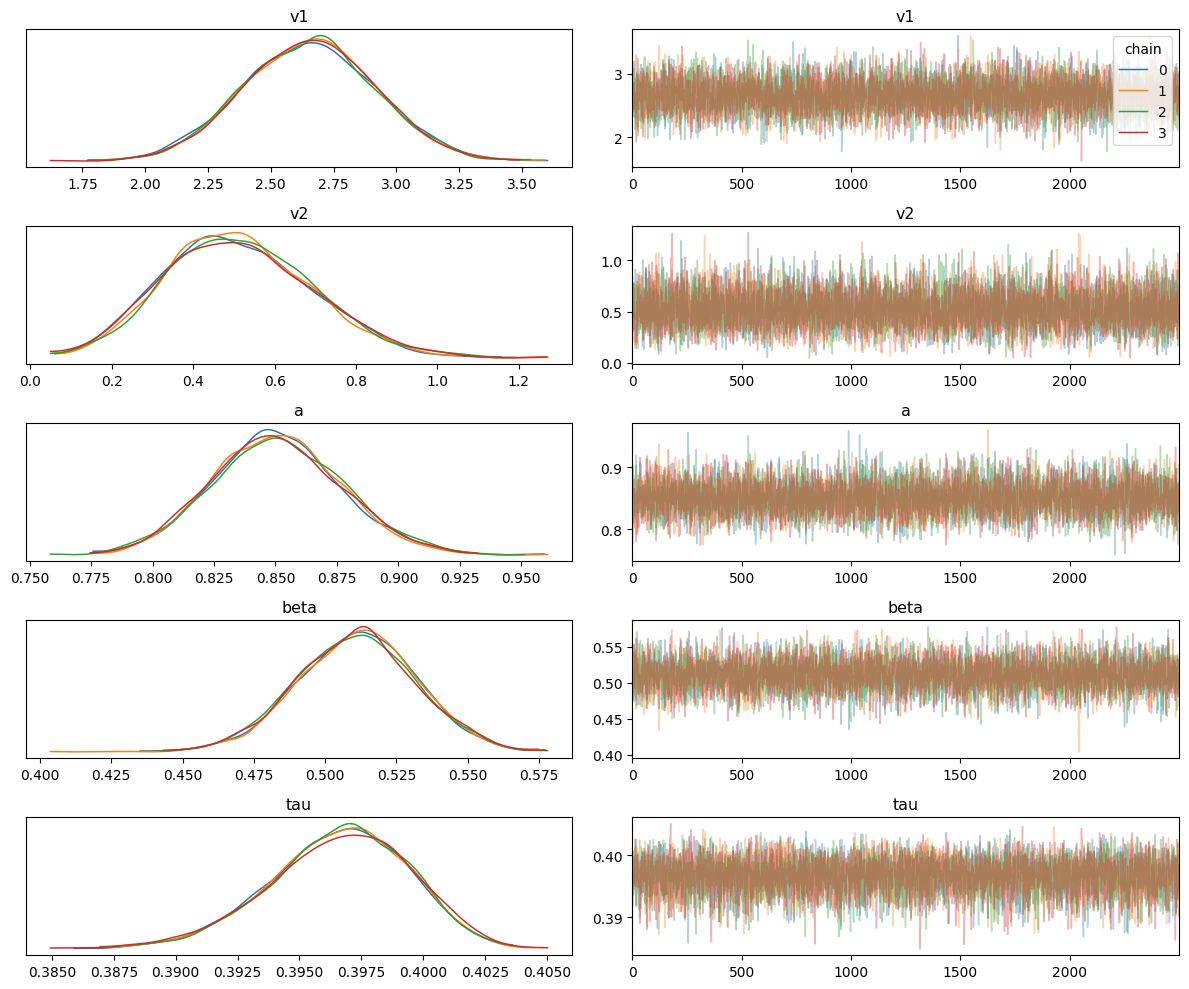

In [11]:
az.plot_trace(fit, var_names=['v1', 'v2', 'a', 'beta', 'tau'], compact=False, legend=True)
plt.tight_layout()

## Analysis

Based on the fitted values of `v1` and `v2`, it is clear that condition 1 is the easier problem and condition 2 is the harder problem because `v2` is a lower drift rate than `v1`. There is a level of uncertainty with both `v1` and `v2`, but even with that uncertainty, there is no overlap between the two distributions.

Additionally, the effective sample size for all parameters is fairly high.